In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import time
import os
import sys
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import linear_theory
import tools

### TNG snapshots

In [3]:
# main inputs
snapshots = np.arange(41, 60).astype(int) # np.arange(63, 73) to center at z=0.5
sigma_z = 0.1  # one of the 5 redshift error bins in SPHEREx

# there is a jump in SPHEREx galaxy number density around z=1; we want to interpolate this
# first get the target number densities
redshifts = np.empty(len(snapshots))
target_ns = np.empty(len(snapshots))
for i, snapshot in enumerate(snapshots):
    sim = TNGSim('TNG300-3', snapshot=snapshot)
    redshifts[i] = sim.redshift
    target_ns[i] = sim.survey_params('SPHEREx', '', sigma_z).n_Mpc3 # * (u.littleh / u.Mpc)**3
target_ns *= (u.littleh / u.Mpc)**3 # return units

# now interpolate
# np.interp needs its x input to _increase_ monotonically, so we need to sort the redshifts
#  (which are currently decreasing monotonically)
idx = np.argsort(redshifts)
redshifts = redshifts[idx]
target_ns = target_ns[idx]
# !! also sort the input snapshots!
snapshots = snapshots[idx]
target_ns_interp = np.interp(redshifts, [redshifts[0], redshifts[-1]], [target_ns[0].value, target_ns[-1].value])

# and if we keep density constant at the mean
target_n = np.mean(target_ns_interp)

Text(0.5, 1.0, 'Target galaxy number densities with $\\sigma_z=$0.1: interpolation')

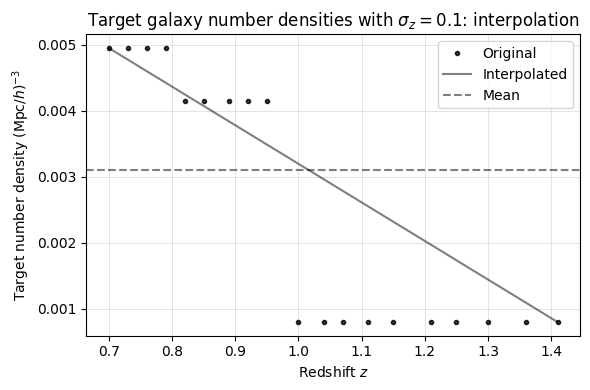

In [4]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(redshifts, target_ns, 'k.', alpha=0.8, label='Original')
ax.plot(redshifts, target_ns_interp, 'k-', alpha=0.5, label='Interpolated')
ax.axhline(target_n, c='k', ls='--', alpha=0.5, label='Mean')
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'Redshift $z$')
ax.set_ylabel(r'Target number density (Mpc/$h)^{-3}$')
ax.legend()
ax.set_title(r'Target galaxy number densities with $\sigma_z=$'f'{sigma_z}: interpolation')

In [5]:
# construct the galaxy samples
data = photxspec.construct_spherex_galaxy_samples(snapshots, sigma_z, ns=target_ns_interp)
redshifts, chis, gal_pos_specs, boxsize = data['redshifts'], data['chis'], data['gal_pos_specs'], data['boxsize']

input number density: 4.95e-03 (h/Mpc)^3
target number of subhalos: 42644
input number density: 4.77e-03 (h/Mpc)^3
target number of subhalos: 41132
input number density: 4.60e-03 (h/Mpc)^3
target number of subhalos: 39620
input number density: 4.42e-03 (h/Mpc)^3
target number of subhalos: 38108
input number density: 4.25e-03 (h/Mpc)^3
target number of subhalos: 36596
input number density: 4.07e-03 (h/Mpc)^3
target number of subhalos: 35084
input number density: 3.84e-03 (h/Mpc)^3
target number of subhalos: 33068
input number density: 3.66e-03 (h/Mpc)^3
target number of subhalos: 31555
input number density: 3.49e-03 (h/Mpc)^3
target number of subhalos: 30043
removing 1 values
input number density: 3.19e-03 (h/Mpc)^3
target number of subhalos: 27523
input number density: 2.96e-03 (h/Mpc)^3
target number of subhalos: 25507
input number density: 2.79e-03 (h/Mpc)^3
target number of subhalos: 23995
input number density: 2.55e-03 (h/Mpc)^3
target number of subhalos: 21979
input number density

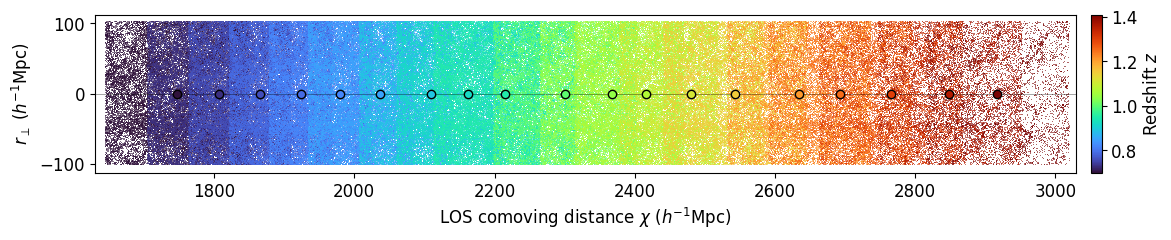

In [10]:
# plot
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(15,2.5), tight_layout=True)
for i, chi in enumerate(chis):
    gal_pos_spec_ = np.copy(gal_pos_specs[i])
    gal_pos_spec_[:,2] += chi
    kwargs = dict(c=smap.to_rgba(redshifts[i]), ls='None')
    ax.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], marker=',', alpha=0.6, **kwargs)
    ax.plot(chi, 0, marker='o', c=smap.to_rgba(redshifts[i]), mec='k', zorder=100)
    ax.axvline((chi - boxsize/2).value, alpha=0.8, **kwargs)
    ax.axvline((chi + boxsize/2).value, alpha=0.8, **kwargs)
ax.axhline(0, c='k', alpha=0.5, lw=0.5)
ax.set_xlim(1630,3030)
ax.set_aspect('equal')
ax.set_xlabel(r'LOS comoving distance $\chi$ ($h^{-1}$Mpc)', size=12)
ax.set_ylabel(r'$r_\perp$ ($h^{-1}$Mpc)', size=12)
# ax.set_title(r'TNG300 snapshots')
cbar = fig.colorbar(smap, ax=ax, pad=0.01, aspect=15)
cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Redshift $z$', size=12)

ax.tick_params(axis='both', which='major', labelsize=12)

### photometric weights

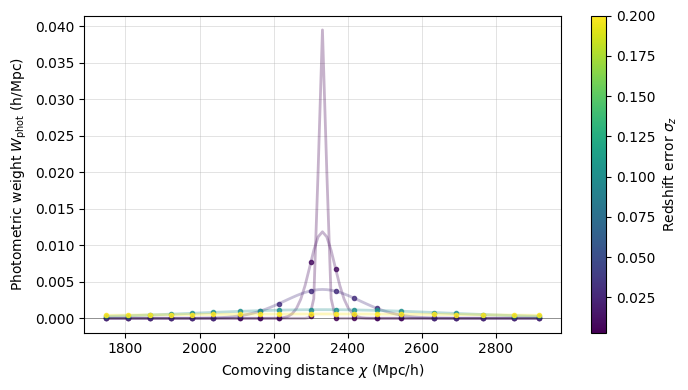

In [13]:
# plot for all sigma_zs
sigma_zs = [0.003, 0.01, 0.03, 0.1, 0.2]

fig, ax = plt.subplots(figsize=(7,4), tight_layout=True)
norm = mpl.colors.Normalize(vmin=min(sigma_zs), vmax=max(sigma_zs))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')
for i, sigma_z_ in enumerate(sigma_zs):
    dx = tools.get_dx(np.nanmean(redshifts), sigma_z_)
    # on a finer grid
    chis_fine = np.linspace(min(chis.value), max(chis.value), 101)
    W_phot_fine = [
        tools.eval_Gaussian(chi, dx.value, mean=np.nanmean(chis_fine)) for chi in chis_fine
    ]
    # and at the snapshot centers
    W_phot = [
        tools.eval_Gaussian(chi.value, dx.value, mean=np.nanmean(chis_fine)) for chi in chis
    ]
    ax.plot(chis_fine, W_phot_fine, ls='-', lw=2, alpha=0.3, c=smap.to_rgba(sigma_z_))
    label = 'Snapshot centers' if i == 0 else ''
    ax.plot(chis.value, W_phot, marker='.', alpha=0.8, ls='None', label=label, c=smap.to_rgba(sigma_z_))
ax.axhline(0, alpha=0.5, c='k', lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
# ax.semilogy()
ax.set_xlabel(r'Comoving distance $\chi$ (Mpc/h)')
ax.set_ylabel(r'Photometric weight $W_\mathrm{phot}$ (h/Mpc)')
# ax.set_title('Photometric weights')
fig.colorbar(smap, ax=ax, label=r'Redshift error $\sigma_z$')

### projected auto-correlation in each snapshot

In [14]:
# INPUTS
randmult = 3
rpmin = 0.1
rpmax = 60
nrpbins = 10
pimax = int(0.45 * boxsize.value) # max depth to integrate along LOS
periodic = True
nrepeats = 10  # how many times to repeat computation to help with noise / numerical errors ?

In [15]:
# compute and store wp(rp) from each reference galaxy sample
wps = np.full((len(snapshots),nrpbins), np.nan)
for i, gal_pos_spec in enumerate(gal_pos_specs):
    print(f"{i+1} / {len(snapshots)}", end='\r')
    rp_avg, wps[i] = corrfuncs.compute_wp_auto(gal_pos_spec, randmult, rpmin, rpmax, nrpbins, pimax,
                    boxsize=boxsize, logbins=True, nrepeats=nrepeats, periodic=periodic)

/work/08811/aew492/frontera/small-scale_cross-corrs/corrfuncs.py:115: RuntimeWarning: Mean of empty slice
  wp = np.nanmean(wps, axis=0)  # get the mean across the runs


#### assume isotropy: compute from $\xi(r)$ ; compare to linear theory

In [16]:
# INPUTS: separation bins
rmin = 0.1
rmax = 100
nbins = 10

In [17]:
# compute the pair counts
xis = np.full((len(snapshots),nbins), np.nan)
for i, gal_pos_spec in enumerate(gal_pos_specs):
    r_avg, xis[i] = corrfuncs.compute_xi_auto(gal_pos_spec, rmin, rmax, nbins, randmult=randmult,
                                             boxsize=boxsize, nrepeats=nrepeats, periodic=periodic)

In [18]:
# get bias from the central snapshot

# instantiate TNG Simulation
idx = np.argmin(np.abs(snapshots-np.mean(snapshots)))
sim = TNGSim('TNG300-3', snapshot=snapshots[idx])
print(f"computing linear theory for snapshot {sim.snapshot}, z={sim.redshift}")

# get linear bias from spectroscopic sample
ratio = linear_theory.get_linear_bias(gal_pos_specs[idx], sim,
                                      method='cross_dm', rmin=rmin, rmax=rmax, nbins=nbins)

# range to compute linear bias
biasrange = [-5,-2] # indices from ravg
bias = np.mean(ratio[biasrange[0]:biasrange[1]])

computing linear theory for snapshot 50, z=1.0
loaded 244140625 dark matter particles


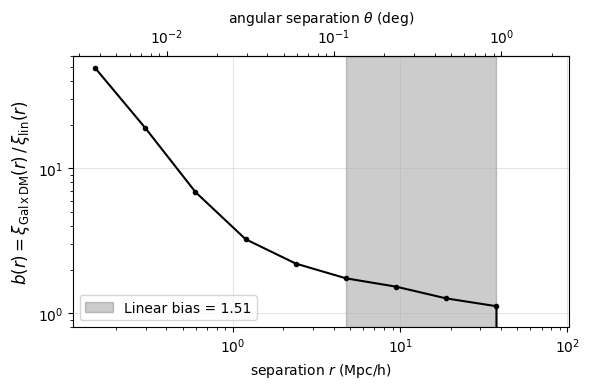

In [19]:
# plot
# ! note redshift needs to be defined in the TNGSim earlier;
#    to use with mpl axis labels, we need a single input and dimensionless output
def theta_to_r_comov_(theta):  # theta in DEGREES
    return tools.theta_to_r_comov(theta, sim.redshift).value
def r_comov_to_theta_(r):
    return tools.r_comov_to_theta(r, sim.redshift).value

fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
ax.plot(r_avg, ratio, 'k.-')
secax = ax.secondary_xaxis('top', functions=(r_comov_to_theta_, theta_to_r_comov_))
secax.set_xlabel(r'angular separation $\theta$ (deg)')
ax.axvspan(r_avg[biasrange[0]], r_avg[biasrange[1]], color='k', alpha=0.2, label=f'Linear bias = {bias:.2f}')
# ax.axvline(r_avg[biasrange[0]], color='k', alpha=0.2, label=f'Linear bias = {bias:.2f}')
# ax.axvline(r_avg[biasrange[1]], color='k', alpha=0.2)
ax.loglog()
ax.set_ylim(8e-1, 6e1)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r$ (Mpc/h)')
ax.set_ylabel(r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$', size=12)
# ax.set_title(f'Galaxy bias, z={sim.redshift}: 'r'$b(r) = \xi_\mathrm{Gal\,x\,DM}(r)\,/\,\xi_\mathrm{lin}(r)$',
#              y=1.2)
ax.legend()

In [20]:
# galaxy c.f. is the matter c.f. times the bias squared
xi_lins = bias**2 * np.array([
    tools.linear_2pcf(redshift, r_avg) for redshift in redshifts
])

In [21]:
# use these xi(r) as a lookup table to interpolate (rp,pi)
rp = rp_avg
pi = rp_avg # also use rp_avg for pi
# populate 2D array of separation r from each (r_p, pi) pair
r_arr = tools.r_from_rppi(rp, pi) 

# linear wp(rp) from linear xi(r)
wps_lin_isotropic = np.full_like(wps, np.nan)
for i, xi_lin in enumerate(xi_lins):
    # interpolate xi(r) on this r_arr grid
    xi_lin_arr = np.exp(np.interp(np.log(r_arr), np.log(r_avg), np.log(xi_lin)))
    # sum over pi / r_parallel to get 1D wp(rp)
    wps_lin_isotropic[i] = 2.0 * integrate.trapz(xi_lin_arr, x=pi, axis=0)

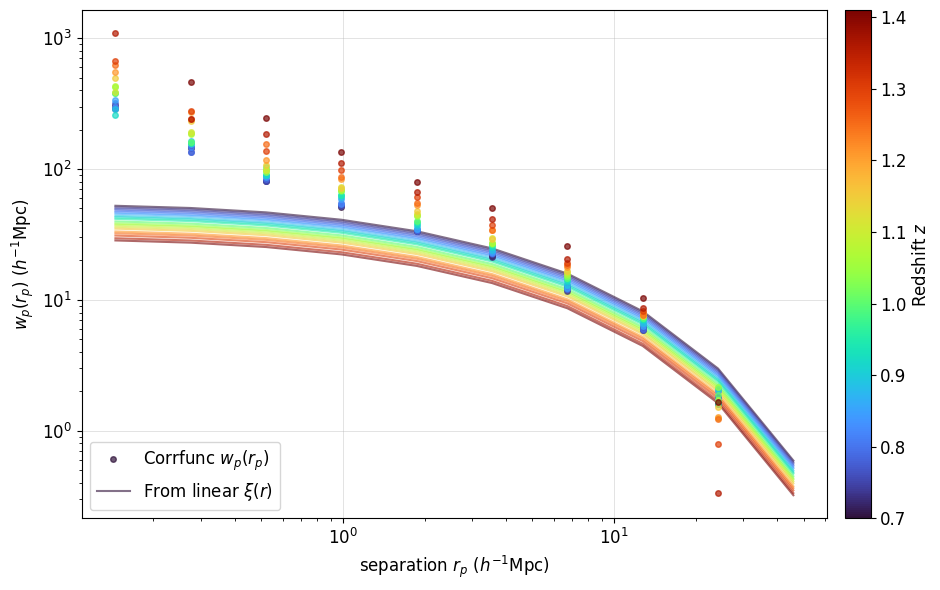

In [33]:
# plot
norm = mpl.colors.Normalize(vmin=min(redshifts), vmax=max(redshifts))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
for i in range(len(snapshots)):
    kwargs = dict(marker='o', ls='None', alpha=0.7, ms=4)
    label = r'Corrfunc $w_p(r_p)$' if i==0 else ''
    ax.plot(rp, wps[i], label=label, c=smap.to_rgba(redshifts[i]), zorder=100, **kwargs)
    label = r'From linear $\xi(r)$' if i==0 else ''
    ax.plot(rp, wps_lin_isotropic[i], alpha=0.6, label=label, c=smap.to_rgba(redshifts[i]))
ax.loglog()
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel(r'separation $r_p$ ($h^{-1}$Mpc)', size=12)
ax.set_ylabel(r'$w_p(r_p)$ ($h^{-1}$Mpc)', size=12)
# ax.set_title(f"Projected autocorrelation, spectroscopic galaxies ("r"$\sigma_z=$"f"{sigma_z})")
ax.legend(loc=3, fontsize=12)
cbar = fig.colorbar(smap, ax=ax, pad=0.02)
cbar.ax.tick_params(labelsize=12) 
cbar.set_label('Redshift $z$', size=12)

ax.tick_params(axis='both', which='major', labelsize=12)

### photometric weights $\rightarrow$ angular cross-correlation

In [31]:
# redshift error in comoving coordinates
dx = tools.get_dx(np.nanmean(redshifts), sigma_z)
print("dx = ", dx)

# on a finer grid
chis_fine = np.linspace(min(chis.value), max(chis.value), 101)
W_phot_fine = [
    tools.eval_Gaussian(chi, dx.value, mean=np.nanmean(chis_fine)) for chi in chis_fine
]
# and at the snapshot centers
W_phot = [
    tools.eval_Gaussian(chi.value, dx.value, mean=np.nanmean(chis_fine)) for chi in chis
]
# multiply each projected auto-correlation function by the corresponding photometric weight
#  this effectively gives us the angular cross-correlation function
wthetax = np.array([
    W_phot[i] * wps[i] for i in range(len(snapshots))
])
wthetax_lin = np.array([
    W_phot[i] * wps_lin_isotropic[i] for i in range(len(snapshots))
])

dx =  336.6220361211222 Mpc / littleh


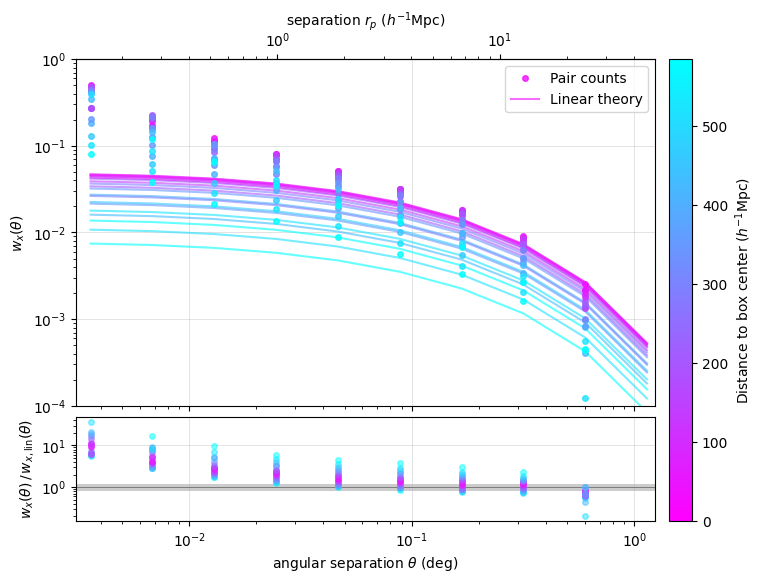

In [36]:
# now color by distance to box center
norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis.value-np.nanmean(chis_fine))))
smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
fig = plt.figure(figsize=(9,6))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)
    
ax0 = fig.add_subplot(gs[0])
thetaavg = r_comov_to_theta_(rp_avg)
for i, w in enumerate(wthetax):
    kwargs = dict(c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
    label = 'Pair counts' if i==len(wthetax)//2 else ''
    ax0.plot(thetaavg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, zorder=100, **kwargs)
    label = 'Linear theory' if i==len(wthetax)//2 else ''
    ax0.plot(thetaavg, wthetax_lin[i], alpha=0.6, label=label, **kwargs)
secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
secax.set_xlabel(r'separation $r_p$ ($h^{-1}$Mpc)')
ax0.set_ylim(1e-4,1e0)
ax0.set_ylabel(r'$w_x(\theta)$')
ax0.legend()

ax1 = fig.add_subplot(gs[1])
ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
for i, w in enumerate(wthetax):
    ax1.plot(thetaavg, w / wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
             c=smap.to_rgba(np.abs(chis[i].value - np.nanmean(chis_fine))))
ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
ax1.set_xlabel(r'angular separation $\theta$ (deg)')

for ax in (ax0, ax1):
    ax.loglog()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlim(min(thetaavg)-5e-4, max(thetaavg)+1e-1)

fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center ($h^{-1}$Mpc)', pad=0.02)
# fig.suptitle('Phot. x spec. cross-correlation ($\sigma_z=$'f'{sigma_z}; d'r'$x=$'f'{dx.value:.0f} Mpc/h)',
#              x=0.45, y=1.)